In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,1449601855,1.001354,0.065186,-0.096520,0.165298,1.000807,1.002259,1.003631,0.837790,6.682252,...,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2


# Interpolating acceleration columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim



# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "Test Gan"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 1000

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 1000

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = False # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 50        # Epoch number to change training epoch ratio
disc_epochs_change = 1      # New number of consecutive epochs to train discriminator
gen_epochs_change = 50      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 18   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 4  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.4    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.6    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.85

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "Accuracy", "fp Rate", "Precision", "Recall", "F1-Score"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            to_train = DISCRIMINATOR
            train_string = "DISC"
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            if print_batches:
                print(f'Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{P:.{dig}f}", f"{R:.{dig}f}", f"{F1:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}", f"{gen_loss.item():.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{P:.{dig}f}", f"{R:.{dig}f}", f"{F1:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/1000] Training: DISC | Loss D: 0.69370, Loss G: 0.72985 | Accuracy: 0.67463 | fpR: 0.00000 | P: 1.00000 | R: 0.03162 | F1: 0.06124
Epoch [2/1000] Training: DISC | Loss D: 0.69265, Loss G: 0.72985 | Accuracy: 0.67198 | fpR: 0.00000 | P: 1.00000 | R: 0.02372 | F1: 0.04629
Epoch [3/1000] Training: DISC | Loss D: 0.69289, Loss G: 0.72880 | Accuracy: 0.66667 | fpR: 0.00000 | P: 1.00000 | R: 0.00791 | F1: 0.01567
Epoch [4/1000] Training: DISC | Loss D: 0.69358, Loss G: 0.72887 | Accuracy: 0.67198 | fpR: 0.00000 | P: 1.00000 | R: 0.02372 | F1: 0.04629
Epoch [5/1000] Training: GEN | Loss D: 0.69336, Loss G: 0.72924 | Accuracy: 0.67198 | fpR: 0.00000 | P: 1.00000 | R: 0.02372 | F1: 0.04629
Epoch [6/1000] Training: GEN | Loss D: 0.69286, Loss G: 0.72912 | Accuracy: 0.67065 | fpR: 0.00000 | P: 1.00000 | R: 0.01976 | F1: 0.03872
Epoch [7/1000] Training: DISC | Loss D: 0.69316, Loss G: 0.72852 | Accuracy: 0.67065 | fpR: 0.00000 | P: 1.00000 | R: 0.01976 | F1: 0.03872
Epoch [8/1000] Trainin

Epoch [59/1000] Training: DISC | Loss D: 0.68986, Loss G: 0.71754 | Accuracy: 0.71049 | fpR: 0.00800 | P: 0.90698 | R: 0.15415 | F1: 0.26327
Epoch [60/1000] Training: DISC | Loss D: 0.69064, Loss G: 0.71657 | Accuracy: 0.70252 | fpR: 0.01600 | P: 0.82222 | R: 0.14625 | F1: 0.24807
Epoch [61/1000] Training: DISC | Loss D: 0.68918, Loss G: 0.71505 | Accuracy: 0.70252 | fpR: 0.01800 | P: 0.80851 | R: 0.15020 | F1: 0.25307
Epoch [62/1000] Training: DISC | Loss D: 0.68914, Loss G: 0.71569 | Accuracy: 0.71182 | fpR: 0.01000 | P: 0.89130 | R: 0.16206 | F1: 0.27399
Epoch [63/1000] Training: DISC | Loss D: 0.69111, Loss G: 0.71667 | Accuracy: 0.70518 | fpR: 0.01600 | P: 0.82979 | R: 0.15415 | F1: 0.25974
Epoch [64/1000] Training: DISC | Loss D: 0.68970, Loss G: 0.71487 | Accuracy: 0.71846 | fpR: 0.01800 | P: 0.84746 | R: 0.19763 | F1: 0.32021
Epoch [65/1000] Training: DISC | Loss D: 0.69051, Loss G: 0.71592 | Accuracy: 0.70651 | fpR: 0.02400 | P: 0.78571 | R: 0.17391 | F1: 0.28449
Epoch [66/100

Epoch [117/1000] Training: DISC | Loss D: 0.67944, Loss G: 0.70788 | Accuracy: 0.74104 | fpR: 0.23200 | P: 0.60000 | R: 0.68775 | F1: 0.64039
Epoch [118/1000] Training: DISC | Loss D: 0.67540, Loss G: 0.70950 | Accuracy: 0.75564 | fpR: 0.21800 | P: 0.62021 | R: 0.70356 | F1: 0.65876
Epoch [119/1000] Training: DISC | Loss D: 0.67724, Loss G: 0.70708 | Accuracy: 0.74900 | fpR: 0.21600 | P: 0.61429 | R: 0.67984 | F1: 0.64491
Epoch [120/1000] Training: DISC | Loss D: 0.67739, Loss G: 0.70835 | Accuracy: 0.75564 | fpR: 0.20400 | P: 0.62637 | R: 0.67589 | F1: 0.64969
Epoch [121/1000] Training: DISC | Loss D: 0.67783, Loss G: 0.71011 | Accuracy: 0.74502 | fpR: 0.22800 | P: 0.60554 | R: 0.69170 | F1: 0.64526
Epoch [122/1000] Training: DISC | Loss D: 0.67342, Loss G: 0.70987 | Accuracy: 0.76892 | fpR: 0.20400 | P: 0.63958 | R: 0.71542 | F1: 0.67488
Epoch [123/1000] Training: DISC | Loss D: 0.67486, Loss G: 0.70960 | Accuracy: 0.73971 | fpR: 0.22800 | P: 0.60000 | R: 0.67589 | F1: 0.63519
Epoch 

Epoch [175/1000] Training: DISC | Loss D: 0.65237, Loss G: 0.71632 | Accuracy: 0.83798 | fpR: 0.14400 | P: 0.73818 | R: 0.80237 | F1: 0.76844
Epoch [176/1000] Training: DISC | Loss D: 0.65698, Loss G: 0.71565 | Accuracy: 0.80876 | fpR: 0.18200 | P: 0.68729 | R: 0.79051 | F1: 0.73480
Epoch [177/1000] Training: DISC | Loss D: 0.65155, Loss G: 0.71631 | Accuracy: 0.81806 | fpR: 0.20200 | P: 0.68239 | R: 0.85771 | F1: 0.75958

Pull Generator

Epoch [178/1000] Training: GEN | Loss D: 0.65599, Loss G: 0.71672 | Accuracy: 0.84064 | fpR: 0.15200 | P: 0.73333 | R: 0.82609 | F1: 0.77645
Epoch [179/1000] Training: DISC | Loss D: 0.65186, Loss G: 0.71828 | Accuracy: 0.84728 | fpR: 0.15000 | P: 0.73958 | R: 0.84190 | F1: 0.78693
Epoch [180/1000] Training: DISC | Loss D: 0.65157, Loss G: 0.71809 | Accuracy: 0.83665 | fpR: 0.17600 | P: 0.71242 | R: 0.86166 | F1: 0.77947

Pull Generator

Epoch [181/1000] Training: GEN | Loss D: 0.64889, Loss G: 0.71663 | Accuracy: 0.81939 | fpR: 0.19000 | P: 0.69055 |

Epoch [231/1000] Training: GEN | Loss D: 0.63642, Loss G: 0.71965 | Accuracy: 0.75432 | fpR: 0.30200 | P: 0.59189 | R: 0.86561 | F1: 0.70257

Pull Generator

Epoch [232/1000] Training: GEN | Loss D: 0.64050, Loss G: 0.71736 | Accuracy: 0.73307 | fpR: 0.31200 | P: 0.57143 | R: 0.82213 | F1: 0.67375
Epoch [233/1000] Training: DISC | Loss D: 0.64097, Loss G: 0.71802 | Accuracy: 0.75963 | fpR: 0.26400 | P: 0.60714 | R: 0.80632 | F1: 0.69221
Epoch [234/1000] Training: DISC | Loss D: 0.62839, Loss G: 0.71928 | Accuracy: 0.79548 | fpR: 0.25200 | P: 0.64103 | R: 0.88933 | F1: 0.74455

Pull Generator

Epoch [235/1000] Training: GEN | Loss D: 0.63690, Loss G: 0.71645 | Accuracy: 0.77822 | fpR: 0.25200 | P: 0.62722 | R: 0.83794 | F1: 0.71694
Epoch [236/1000] Training: DISC | Loss D: 0.63724, Loss G: 0.71842 | Accuracy: 0.75166 | fpR: 0.29200 | P: 0.59218 | R: 0.83794 | F1: 0.69346
Epoch [237/1000] Training: DISC | Loss D: 0.63604, Loss G: 0.72017 | Accuracy: 0.75564 | fpR: 0.30000 | P: 0.59350 | 

Epoch [286/1000] Training: GEN | Loss D: 0.63251, Loss G: 0.70330 | Accuracy: 0.66135 | fpR: 0.45800 | P: 0.49781 | R: 0.89723 | F1: 0.63988
Epoch [287/1000] Training: DISC | Loss D: 0.63986, Loss G: 0.70397 | Accuracy: 0.64276 | fpR: 0.45600 | P: 0.48182 | R: 0.83794 | F1: 0.61137
Epoch [288/1000] Training: DISC | Loss D: 0.63173, Loss G: 0.70643 | Accuracy: 0.68260 | fpR: 0.42800 | P: 0.51584 | R: 0.90119 | F1: 0.65565
Epoch [289/1000] Training: DISC | Loss D: 0.63426, Loss G: 0.70751 | Accuracy: 0.70252 | fpR: 0.39200 | P: 0.53444 | R: 0.88933 | F1: 0.66719

Pull Generator

Epoch [290/1000] Training: GEN | Loss D: 0.63276, Loss G: 0.70484 | Accuracy: 0.69057 | fpR: 0.39600 | P: 0.52404 | R: 0.86166 | F1: 0.65125

Pull Generator

Epoch [291/1000] Training: GEN | Loss D: 0.63815, Loss G: 0.70028 | Accuracy: 0.67065 | fpR: 0.42800 | P: 0.50577 | R: 0.86561 | F1: 0.63802
Epoch [292/1000] Training: DISC | Loss D: 0.64203, Loss G: 0.70283 | Accuracy: 0.67065 | fpR: 0.42800 | P: 0.50577 | 

Epoch [343/1000] Training: DISC | Loss D: 0.62084, Loss G: 0.70784 | Accuracy: 0.70518 | fpR: 0.38200 | P: 0.53753 | R: 0.87747 | F1: 0.66620

Pull Generator

Epoch [344/1000] Training: GEN | Loss D: 0.62463, Loss G: 0.70404 | Accuracy: 0.66667 | fpR: 0.43400 | P: 0.50229 | R: 0.86561 | F1: 0.63524
Epoch [345/1000] Training: DISC | Loss D: 0.62116, Loss G: 0.70677 | Accuracy: 0.68526 | fpR: 0.41200 | P: 0.51869 | R: 0.87747 | F1: 0.65152
Epoch [346/1000] Training: DISC | Loss D: 0.61709, Loss G: 0.70918 | Accuracy: 0.70651 | fpR: 0.38400 | P: 0.53846 | R: 0.88538 | F1: 0.66919

Pull Generator

Epoch [347/1000] Training: GEN | Loss D: 0.62730, Loss G: 0.70518 | Accuracy: 0.70120 | fpR: 0.39400 | P: 0.53318 | R: 0.88933 | F1: 0.66620

Pull Generator

Epoch [348/1000] Training: GEN | Loss D: 0.62278, Loss G: 0.69830 | Accuracy: 0.67331 | fpR: 0.42600 | P: 0.50808 | R: 0.86957 | F1: 0.64093
Epoch [349/1000] Training: DISC | Loss D: 0.62300, Loss G: 0.70429 | Accuracy: 0.68526 | fpR: 0.4120

Epoch [399/1000] Training: DISC | Loss D: 0.61832, Loss G: 0.70837 | Accuracy: 0.69190 | fpR: 0.40800 | P: 0.52448 | R: 0.88933 | F1: 0.65936
Epoch [400/1000] Training: DISC | Loss D: 0.61477, Loss G: 0.71290 | Accuracy: 0.69854 | fpR: 0.39000 | P: 0.53125 | R: 0.87352 | F1: 0.66022

Pull Generator

Epoch [401/1000] Training: GEN | Loss D: 0.61194, Loss G: 0.70871 | Accuracy: 0.67729 | fpR: 0.40400 | P: 0.51208 | R: 0.83794 | F1: 0.63521
Epoch [402/1000] Training: DISC | Loss D: 0.61267, Loss G: 0.71097 | Accuracy: 0.69057 | fpR: 0.38800 | P: 0.52451 | R: 0.84585 | F1: 0.64703
Epoch [403/1000] Training: DISC | Loss D: 0.61576, Loss G: 0.71504 | Accuracy: 0.68393 | fpR: 0.40000 | P: 0.51807 | R: 0.84980 | F1: 0.64324
Epoch [404/1000] Training: DISC | Loss D: 0.62315, Loss G: 0.71385 | Accuracy: 0.70784 | fpR: 0.35800 | P: 0.54220 | R: 0.83794 | F1: 0.65791
Epoch [405/1000] Training: DISC | Loss D: 0.61507, Loss G: 0.71744 | Accuracy: 0.74635 | fpR: 0.32800 | P: 0.57949 | R: 0.89328 | F1

Epoch [457/1000] Training: DISC | Loss D: 0.59267, Loss G: 0.76402 | Accuracy: 0.78220 | fpR: 0.23800 | P: 0.63609 | R: 0.82213 | F1: 0.71675
Epoch [458/1000] Training: DISC | Loss D: 0.59764, Loss G: 0.76162 | Accuracy: 0.75299 | fpR: 0.26800 | P: 0.60000 | R: 0.79447 | F1: 0.68318
Epoch [459/1000] Training: DISC | Loss D: 0.59599, Loss G: 0.76544 | Accuracy: 0.77025 | fpR: 0.24000 | P: 0.62500 | R: 0.79051 | F1: 0.69759
Epoch [460/1000] Training: DISC | Loss D: 0.59775, Loss G: 0.76983 | Accuracy: 0.79283 | fpR: 0.20800 | P: 0.65902 | R: 0.79447 | F1: 0.71993
Epoch [461/1000] Training: DISC | Loss D: 0.59502, Loss G: 0.77108 | Accuracy: 0.77822 | fpR: 0.24000 | P: 0.63190 | R: 0.81423 | F1: 0.71108
Epoch [462/1000] Training: DISC | Loss D: 0.59825, Loss G: 0.76777 | Accuracy: 0.76627 | fpR: 0.23400 | P: 0.62379 | R: 0.76680 | F1: 0.68745
Epoch [463/1000] Training: DISC | Loss D: 0.58687, Loss G: 0.77127 | Accuracy: 0.77556 | fpR: 0.23000 | P: 0.63376 | R: 0.78656 | F1: 0.70145
Epoch 


Pull Generator

Epoch [516/1000] Training: GEN | Loss D: 0.57357, Loss G: 0.76789 | Accuracy: 0.76228 | fpR: 0.27800 | P: 0.60511 | R: 0.84190 | F1: 0.70365
Epoch [517/1000] Training: DISC | Loss D: 0.56793, Loss G: 0.77210 | Accuracy: 0.77955 | fpR: 0.25200 | P: 0.62832 | R: 0.84190 | F1: 0.71911
Epoch [518/1000] Training: DISC | Loss D: 0.56787, Loss G: 0.77772 | Accuracy: 0.75697 | fpR: 0.28400 | P: 0.59887 | R: 0.83794 | F1: 0.69803
Epoch [519/1000] Training: DISC | Loss D: 0.58240, Loss G: 0.77630 | Accuracy: 0.76892 | fpR: 0.28000 | P: 0.61003 | R: 0.86561 | F1: 0.71520

Pull Generator

Epoch [520/1000] Training: GEN | Loss D: 0.57427, Loss G: 0.77584 | Accuracy: 0.75432 | fpR: 0.26800 | P: 0.60119 | R: 0.79842 | F1: 0.68542
Epoch [521/1000] Training: DISC | Loss D: 0.57196, Loss G: 0.77618 | Accuracy: 0.76627 | fpR: 0.28400 | P: 0.60665 | R: 0.86561 | F1: 0.71287

Pull Generator

Epoch [522/1000] Training: GEN | Loss D: 0.57308, Loss G: 0.76628 | Accuracy: 0.74900 | fpR: 0.2700

Epoch [574/1000] Training: DISC | Loss D: 0.55092, Loss G: 0.85254 | Accuracy: 0.81009 | fpR: 0.20000 | P: 0.67742 | R: 0.83004 | F1: 0.74551
Epoch [575/1000] Training: DISC | Loss D: 0.54089, Loss G: 0.85373 | Accuracy: 0.83798 | fpR: 0.16400 | P: 0.72203 | R: 0.84190 | F1: 0.77688
Epoch [576/1000] Training: DISC | Loss D: 0.54009, Loss G: 0.85673 | Accuracy: 0.83134 | fpR: 0.18200 | P: 0.70455 | R: 0.85771 | F1: 0.77312

Pull Generator

Epoch [577/1000] Training: GEN | Loss D: 0.52852, Loss G: 0.84936 | Accuracy: 0.81275 | fpR: 0.20000 | P: 0.67949 | R: 0.83794 | F1: 0.74995
Epoch [578/1000] Training: DISC | Loss D: 0.52932, Loss G: 0.84644 | Accuracy: 0.81142 | fpR: 0.18800 | P: 0.68562 | R: 0.81028 | F1: 0.74226
Epoch [579/1000] Training: DISC | Loss D: 0.53592, Loss G: 0.85283 | Accuracy: 0.82470 | fpR: 0.18600 | P: 0.69707 | R: 0.84585 | F1: 0.76379
Epoch [580/1000] Training: DISC | Loss D: 0.54025, Loss G: 0.85043 | Accuracy: 0.80345 | fpR: 0.19600 | P: 0.67442 | R: 0.80237 | F1

Epoch [632/1000] Training: DISC | Loss D: 0.50853, Loss G: 0.92260 | Accuracy: 0.81939 | fpR: 0.16800 | P: 0.70526 | R: 0.79447 | F1: 0.74671
Epoch [633/1000] Training: DISC | Loss D: 0.50484, Loss G: 0.91757 | Accuracy: 0.84329 | fpR: 0.15800 | P: 0.73038 | R: 0.84585 | F1: 0.78339
Epoch [634/1000] Training: DISC | Loss D: 0.49380, Loss G: 0.92084 | Accuracy: 0.82470 | fpR: 0.17000 | P: 0.70790 | R: 0.81423 | F1: 0.75686
Epoch [635/1000] Training: DISC | Loss D: 0.49827, Loss G: 0.93222 | Accuracy: 0.83798 | fpR: 0.14200 | P: 0.73993 | R: 0.79842 | F1: 0.76756
Epoch [636/1000] Training: DISC | Loss D: 0.49719, Loss G: 0.93504 | Accuracy: 0.83400 | fpR: 0.15600 | P: 0.72535 | R: 0.81423 | F1: 0.76673
Epoch [637/1000] Training: DISC | Loss D: 0.50053, Loss G: 0.93185 | Accuracy: 0.83134 | fpR: 0.14600 | P: 0.73162 | R: 0.78656 | F1: 0.75760
Epoch [638/1000] Training: DISC | Loss D: 0.47579, Loss G: 0.94288 | Accuracy: 0.84861 | fpR: 0.13200 | P: 0.75646 | R: 0.81028 | F1: 0.78194
Epoch 

Epoch [691/1000] Training: DISC | Loss D: 0.45899, Loss G: 0.99613 | Accuracy: 0.84064 | fpR: 0.15000 | P: 0.73498 | R: 0.82213 | F1: 0.77562
Epoch [692/1000] Training: DISC | Loss D: 0.47542, Loss G: 1.00488 | Accuracy: 0.84595 | fpR: 0.13600 | P: 0.75092 | R: 0.81028 | F1: 0.77897
Epoch [693/1000] Training: DISC | Loss D: 0.47883, Loss G: 0.99914 | Accuracy: 0.84462 | fpR: 0.14000 | P: 0.74638 | R: 0.81423 | F1: 0.77833
Epoch [694/1000] Training: DISC | Loss D: 0.44337, Loss G: 1.01141 | Accuracy: 0.85259 | fpR: 0.11800 | P: 0.77308 | R: 0.79447 | F1: 0.78313
Epoch [695/1000] Training: DISC | Loss D: 0.45949, Loss G: 1.00890 | Accuracy: 0.86985 | fpR: 0.11400 | P: 0.78810 | R: 0.83794 | F1: 0.81176
Epoch [696/1000] Training: DISC | Loss D: 0.46147, Loss G: 1.01042 | Accuracy: 0.84595 | fpR: 0.13000 | P: 0.75655 | R: 0.79842 | F1: 0.77642
Epoch [697/1000] Training: DISC | Loss D: 0.46334, Loss G: 1.02658 | Accuracy: 0.87118 | fpR: 0.10400 | P: 0.80000 | R: 0.82213 | F1: 0.81042
Epoch 

Epoch [751/1000] Training: DISC | Loss D: 0.44643, Loss G: 1.06768 | Accuracy: 0.84462 | fpR: 0.14000 | P: 0.74638 | R: 0.81423 | F1: 0.77833
Epoch [752/1000] Training: DISC | Loss D: 0.43189, Loss G: 1.08027 | Accuracy: 0.85126 | fpR: 0.12600 | P: 0.76404 | R: 0.80632 | F1: 0.78412
Epoch [753/1000] Training: DISC | Loss D: 0.44298, Loss G: 1.07952 | Accuracy: 0.86587 | fpR: 0.11800 | P: 0.78148 | R: 0.83399 | F1: 0.80638
Epoch [754/1000] Training: DISC | Loss D: 0.43217, Loss G: 1.09021 | Accuracy: 0.86321 | fpR: 0.12000 | P: 0.77778 | R: 0.83004 | F1: 0.80256
Epoch [755/1000] Training: DISC | Loss D: 0.43456, Loss G: 1.10034 | Accuracy: 0.86853 | fpR: 0.11600 | P: 0.78519 | R: 0.83794 | F1: 0.81021
Epoch [756/1000] Training: DISC | Loss D: 0.40558, Loss G: 1.07857 | Accuracy: 0.85790 | fpR: 0.12800 | P: 0.76642 | R: 0.83004 | F1: 0.79647
Epoch [757/1000] Training: DISC | Loss D: 0.44451, Loss G: 1.09203 | Accuracy: 0.85790 | fpR: 0.10800 | P: 0.78740 | R: 0.79051 | F1: 0.78845
Epoch 

Epoch [808/1000] Training: DISC | Loss D: 0.47787, Loss G: 1.09166 | Accuracy: 0.83001 | fpR: 0.13400 | P: 0.74131 | R: 0.75889 | F1: 0.74950
Epoch [809/1000] Training: DISC | Loss D: 0.46722, Loss G: 1.08730 | Accuracy: 0.82072 | fpR: 0.14800 | P: 0.72180 | R: 0.75889 | F1: 0.73939
Epoch [810/1000] Training: DISC | Loss D: 0.45239, Loss G: 1.08423 | Accuracy: 0.84462 | fpR: 0.11800 | P: 0.76772 | R: 0.77075 | F1: 0.76873
Epoch [811/1000] Training: DISC | Loss D: 0.47384, Loss G: 1.09084 | Accuracy: 0.82205 | fpR: 0.12800 | P: 0.74089 | R: 0.72332 | F1: 0.73150
Epoch [812/1000] Training: DISC | Loss D: 0.47618, Loss G: 1.09520 | Accuracy: 0.81142 | fpR: 0.15400 | P: 0.70943 | R: 0.74308 | F1: 0.72537
Epoch [813/1000] Training: DISC | Loss D: 0.46981, Loss G: 1.09592 | Accuracy: 0.79681 | fpR: 0.15800 | P: 0.69380 | R: 0.70751 | F1: 0.70009
Epoch [814/1000] Training: DISC | Loss D: 0.44154, Loss G: 1.10449 | Accuracy: 0.84064 | fpR: 0.13000 | P: 0.75285 | R: 0.78261 | F1: 0.76694
Epoch 

Epoch [868/1000] Training: DISC | Loss D: 0.40362, Loss G: 1.19733 | Accuracy: 0.87782 | fpR: 0.09800 | P: 0.81081 | R: 0.83004 | F1: 0.81981
Epoch [869/1000] Training: DISC | Loss D: 0.39067, Loss G: 1.21529 | Accuracy: 0.84595 | fpR: 0.12600 | P: 0.76046 | R: 0.79051 | F1: 0.77469
Epoch [870/1000] Training: DISC | Loss D: 0.39024, Loss G: 1.19681 | Accuracy: 0.86587 | fpR: 0.11600 | P: 0.78358 | R: 0.83004 | F1: 0.80564
Epoch [871/1000] Training: DISC | Loss D: 0.38685, Loss G: 1.21418 | Accuracy: 0.87251 | fpR: 0.11800 | P: 0.78545 | R: 0.85375 | F1: 0.81768

Pull Generator

Epoch [872/1000] Training: GEN | Loss D: 0.43100, Loss G: 1.17537 | Accuracy: 0.84993 | fpR: 0.11600 | P: 0.77344 | R: 0.78261 | F1: 0.77750
Epoch [873/1000] Training: DISC | Loss D: 0.40016, Loss G: 1.16512 | Accuracy: 0.86454 | fpR: 0.12200 | P: 0.77656 | R: 0.83794 | F1: 0.80558
Epoch [874/1000] Training: DISC | Loss D: 0.40902, Loss G: 1.19099 | Accuracy: 0.84595 | fpR: 0.12600 | P: 0.76046 | R: 0.79051 | F1

Epoch [926/1000] Training: DISC | Loss D: 0.38475, Loss G: 1.22743 | Accuracy: 0.82470 | fpR: 0.15200 | P: 0.72161 | R: 0.77866 | F1: 0.74855
Epoch [927/1000] Training: DISC | Loss D: 0.39084, Loss G: 1.22885 | Accuracy: 0.84462 | fpR: 0.12600 | P: 0.75954 | R: 0.78656 | F1: 0.77232
Epoch [928/1000] Training: DISC | Loss D: 0.38284, Loss G: 1.23919 | Accuracy: 0.86853 | fpR: 0.10600 | P: 0.79615 | R: 0.81818 | F1: 0.80652
Epoch [929/1000] Training: DISC | Loss D: 0.40265, Loss G: 1.24395 | Accuracy: 0.89110 | fpR: 0.07600 | P: 0.84615 | R: 0.82609 | F1: 0.83550
Epoch [930/1000] Training: DISC | Loss D: 0.39937, Loss G: 1.25829 | Accuracy: 0.85657 | fpR: 0.11000 | P: 0.78431 | R: 0.79051 | F1: 0.78690
Epoch [931/1000] Training: DISC | Loss D: 0.40156, Loss G: 1.26747 | Accuracy: 0.87915 | fpR: 0.08800 | P: 0.82400 | R: 0.81423 | F1: 0.81859
Epoch [932/1000] Training: DISC | Loss D: 0.37594, Loss G: 1.26214 | Accuracy: 0.86321 | fpR: 0.11400 | P: 0.78409 | R: 0.81818 | F1: 0.80027
Epoch 

Epoch [985/1000] Training: DISC | Loss D: 0.37680, Loss G: 1.32481 | Accuracy: 0.86853 | fpR: 0.09800 | P: 0.80556 | R: 0.80237 | F1: 0.80346
Epoch [986/1000] Training: DISC | Loss D: 0.36417, Loss G: 1.32396 | Accuracy: 0.88977 | fpR: 0.08400 | P: 0.83465 | R: 0.83794 | F1: 0.83579
Epoch [987/1000] Training: DISC | Loss D: 0.36639, Loss G: 1.32131 | Accuracy: 0.87915 | fpR: 0.10200 | P: 0.80682 | R: 0.84190 | F1: 0.82349
Epoch [988/1000] Training: DISC | Loss D: 0.36057, Loss G: 1.34129 | Accuracy: 0.88446 | fpR: 0.08800 | P: 0.82677 | R: 0.83004 | F1: 0.82790
Epoch [989/1000] Training: DISC | Loss D: 0.35064, Loss G: 1.35323 | Accuracy: 0.88181 | fpR: 0.08000 | P: 0.83607 | R: 0.80632 | F1: 0.82043
Epoch [990/1000] Training: DISC | Loss D: 0.36141, Loss G: 1.35636 | Accuracy: 0.90837 | fpR: 0.06400 | P: 0.87097 | R: 0.85375 | F1: 0.86178

Pull Generator

Epoch [991/1000] Training: GEN | Loss D: 0.36347, Loss G: 1.28444 | Accuracy: 0.86189 | fpR: 0.11800 | P: 0.77903 | R: 0.82213 | F1

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
#torch.save(gen.state_dict(), "../saved_models/test_gan")
#torch.save(disc.state_dict(), "../saved_models/test_disc")

# Visualizing Generation Quality

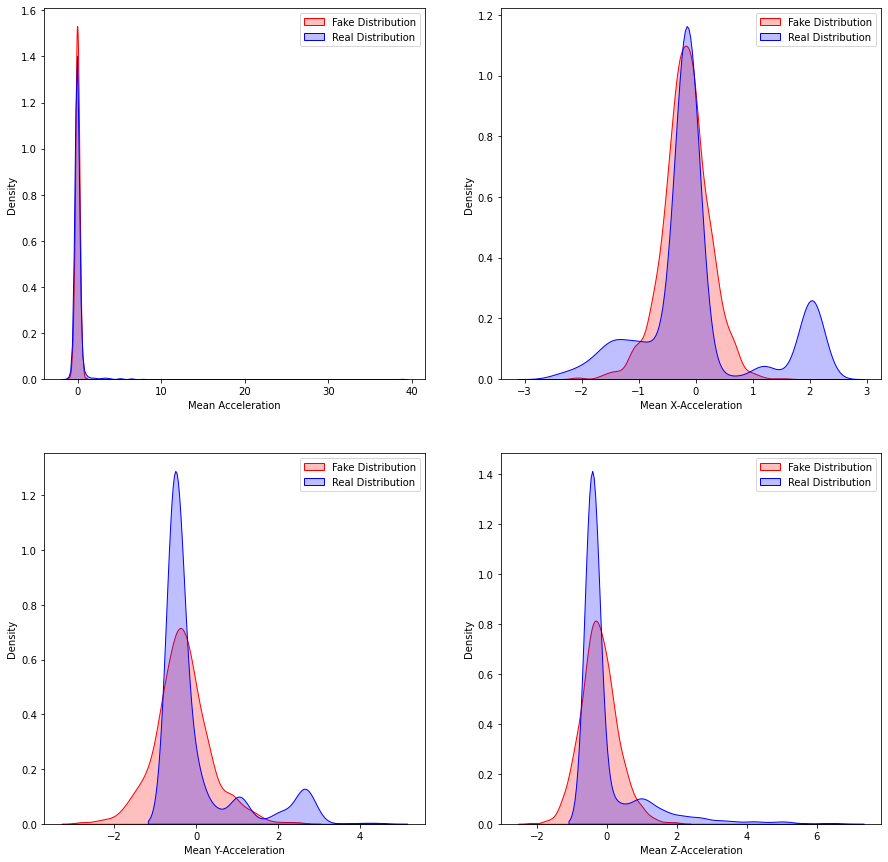

In [10]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)